In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

a good start would be to look at some randomly simulated games, where each player just picks a point on a board

In [2]:
def randgame1(n,p):
    w = 0
    for k in range(p):
        mx = np.zeros((n,n), int)
        choices = np.random.choice(mx.size, int(np.ceil(n*n/2)), replace=False)
        mx.ravel()[choices] = 1

        if np.linalg.det(mx) == 0:
            w = w+1
    return w, w/p

In [3]:
def randgame0(n,p):
    w = 0
    for k in range(p):
        mx = np.zeros((n,n), int)
        choices = np.random.choice(mx.size, int(np.floor(n*n/2)), replace=False)
        mx.ravel()[choices] = 1

        if np.linalg.det(mx) == 0:
            w = w+1
    return w, w/p

In [4]:
print(randgame1(3,1000), 'winning games & ratio of winning games')
print(randgame0(3,1000), 'winning games & ratio of winning games')


(407, 0.407) winning games & ratio of winning games
(717, 0.717) winning games & ratio of winning games


i want code that just tries every possible combination instead of random matrices, to get an accurate idea of how many winning/losing games there are for each player

In [5]:
def shuffle(n, k): #shuffle the string of 1s and 0s giving every combinatorial combination
    result = []
    for ones in itertools.combinations(range(n), k):
        s = ['0'] * n
        for bit in ones:
            s[bit] = '1'
        result.append(''.join(s))
    return result


In [6]:
def deterministicmx(n, p0=True):
    w = 0
    r = []

    if p0:
        j = int(np.floor(n*n/2))
    else:
        j = int(np.ceil(n*n/2))

    flatmxs = shuffle(n*n, j)

    for s in flatmxs:
        mxstr = np.array(list(map(int, s)), dtype=int)
        mx = mxstr.reshape(n, n)

        r.append(int(np.linalg.matrix_rank(mx))) 

        # account for floating point error
        if abs(np.linalg.det(mx)) < 1e-12:
            w += 1

    return len(flatmxs), w, r

In [7]:
for N in range(1,6):

    a,b,x= deterministicmx(N)
    a,c,x= deterministicmx(N, False)

    print(f'Number of possible finished games for N = {N} is {a}: when both players play randomly we get')
    print(f'Player 0 wins {b} times out of {a}, {b*100/a}% when P0 starts')
    print(f'Player 1 wins {a-b} times out of {a}, {(a-b)*100/a}% when P0 starts')
    print(f'Player 0 wins {c} times out of {a}, {(c)*100/a}% when P1 starts')
    print(f'Player 1 wins {a-c} times out of {a}, {(a-c)*100/a}% when P1 starts')

Number of possible finished games for N = 1 is 1: when both players play randomly we get
Player 0 wins 1 times out of 1, 100.0% when P0 starts
Player 1 wins 0 times out of 1, 0.0% when P0 starts
Player 0 wins 0 times out of 1, 0.0% when P1 starts
Player 1 wins 1 times out of 1, 100.0% when P1 starts
Number of possible finished games for N = 2 is 6: when both players play randomly we get
Player 0 wins 4 times out of 6, 66.66666666666667% when P0 starts
Player 1 wins 2 times out of 6, 33.333333333333336% when P0 starts
Player 0 wins 4 times out of 6, 66.66666666666667% when P1 starts
Player 1 wins 2 times out of 6, 33.333333333333336% when P1 starts
Number of possible finished games for N = 3 is 126: when both players play randomly we get
Player 0 wins 90 times out of 126, 71.42857142857143% when P0 starts
Player 1 wins 36 times out of 126, 28.571428571428573% when P0 starts
Player 0 wins 54 times out of 126, 42.857142857142854% when P1 starts
Player 1 wins 72 times out of 126, 57.142857

In [8]:
#.  a,b = deterministicmx(6)
#.  a,c = deterministicmx(6, False)

    #print('Number of possible finished games for N=6', a)
#print('Player 0 wins ', b, 'times out of', a,',', b*100/a ,'% when P0 starts')
#print('Player 1 wins ', a-c, 'times out of', a,',', (a-c)*100/a, '% when P1 starts')

This would take over 80 hours to run on my computers, as 36 Choose 18 is 9075135300, aka the number of different possible games.
here is a reasonable place to stop

we can see that when n is even we get the same results no matter which player starts, this is a bad approximation of a real life game as players will play reactivly not blindly to previous moves.

Although this time could be halved as we know the set of outcome games will be the same no matter who starts, as there is an even number of elements in a 6x6 matrix, thus we would only need to compute determinmx(6), we could also remove combinations which are just rotations or row/column shuffels of other matrices, as these operations dont change the determinant value but this is just a test so we dont really care.

For the extension, i want to find the distrinution of ranks for some different NxN matrices, to see if the game would be fair

In [9]:
def _rank_counts_from_ranks(ranks, n):
    ranks = np.asarray(ranks, dtype=int)
    return np.bincount(ranks, minlength=n+1)[:n+1]

def plot_rank_pies(a, b, c, *, base_font=32, title_font=32, caption_font=32):

    plt.rcParams.update({
        "font.size": base_font,
        "axes.titlesize": title_font,
        "legend.fontsize": base_font,
    })

    ns = (a, b, c) # size of matrices we want to check
    fig, axes = plt.subplots(1, len(ns), figsize=(6 * len(ns), 6))
    if len(ns) == 1:
        axes = [axes]

    # make colours uniform across plots
    max_rank = max(ns)
    cmap = plt.get_cmap("tab10")
    rank_colours = [cmap(k) for k in range(max_rank + 1)]

    for ax, n in zip(axes, ns):
        tot0, w0, r0 = deterministicmx(n, p0=True)     # inner ring (P0 starts)
        tot1, w1, r1 = deterministicmx(n, p0=False)    # outer ring (P1 starts)

        inner = _rank_counts_from_ranks(r0, n)
        outer = _rank_counts_from_ranks(r1, n)

        colors = rank_colours[:n+1]

        # Outer ring plot
        ax.pie(
            outer,
            radius=1.0,
            labels=[""] * (n + 1),
            colors=colors,
            startangle=90,
            counterclock=False,
            wedgeprops=dict(width=0.30, edgecolor="white"),
            textprops=dict(fontsize=base_font),
        )

        # Inner ring plot
        ax.pie(
            inner,
            radius=0.70,
            labels=[""] * (n + 1),
            colors=colors,
            startangle=90,
            counterclock=False,
            wedgeprops=dict(width=0.30, edgecolor="white"),
            textprops=dict(fontsize=base_font),
        )

        ax.set_title(f"n={n}\nNo. Matrices: {tot0 +tot1}")

    # colour key across the bottom, so we know what we are looking at
    handles = []
    labels = []
    for k in range(max_rank + 1):
        handles.append(
            plt.Line2D(
                [0], [0],
                marker="s",
                linestyle="",
                markersize=36,
                markerfacecolor=rank_colours[k],
                markeredgecolor="none",
            )
        )
        labels.append(f"rank {k}")

    fig.legend(
        handles, labels,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.06),
        ncol=max_rank + 1,
        frameon=False,
        handletextpad=0.6,
        columnspacing=1.2,
    )
    #text across bottom to explain p0 and p1 donut graph dist
    fig.text(
        0.5, 0.02,
        "Inner pie: Player 0 starts. Outer pie: Player 1 starts. Colours indicate rank.",
        ha="center",
        fontsize=caption_font
    )

    plt.tight_layout(rect=[0, 0.12, 1, 1])
    plt.show()



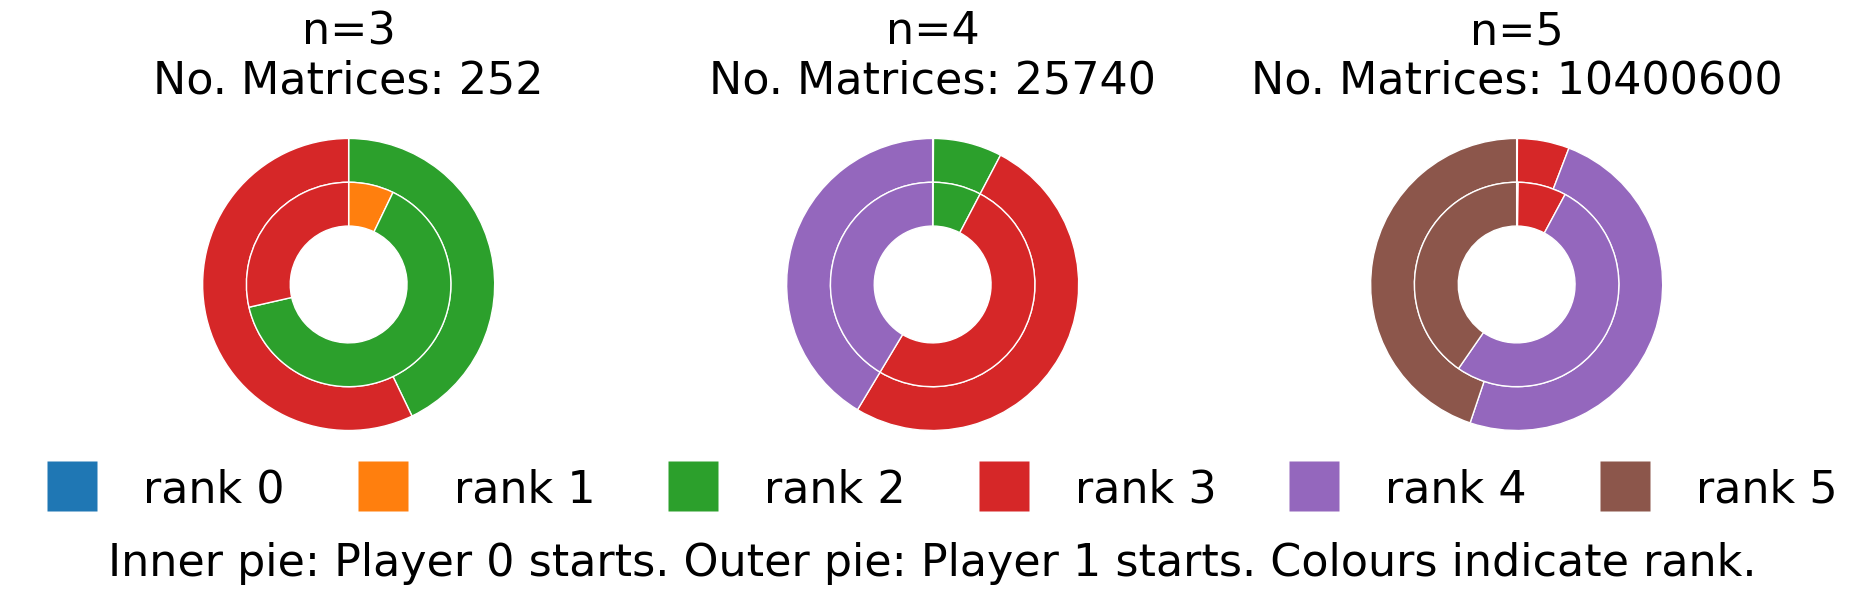

In [10]:
plot_rank_pies(3,4,5)